# PDE-Learning of spin dynamics in XXZ model: Domain wall initial state at zero temperature


In [151]:
%pylab inline
%load_ext autoreload
%autoreload 2

import sys
import time
import numpy as np 
sys.path.insert(0, "../")

from PDE_search import build_custom_Theta, BruteForceL0, TotalFiniteDiff_t, TotalFiniteDiff, build_Theta,\
TrainSTRidge, print_pde, build_linear_system, PolyDiff, TotalPolyDiff

from scipy.signal import savgol_filter
from utils import scalar_pde_solver, save_dict, load_dict, get_u_term_from_descr

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# In this example we consider evolution of a domain wall initial state in a ferromagnetic XXZ spin chain.
The Hamiltonian of the model reads:
$$ H = -\sum_i \left[ J(S^{x}_i S_{x+1} + S^y_{i} S^y_{i+1})+\Delta S^z_i S^z_{i+1} \right]$$
The initial state is a product state: $$|\psi_0\rangle = |\downarrow \downarrow \ldots \downarrow \uparrow \uparrow \ldots \uparrow \rangle.$$

The dynamics of the onsite magnetization in the continuous limit is described by the following nonlinear PDE [1]:
$$u_t + \zeta_0 \sin{\left(\frac{2 \pi}{P} u\right)}   u_x = 0; \quad u(t, x_i) = \langle\psi(t)|S_i^z|\psi(t)\rangle,$$
where the values of the anisotropy parameter should satisfy  $\Delta = \cos{(\pi Q/ P)}$ with $Q,P\in\mathbb Z$ being coprime integers, and $\zeta_0 = \frac{\sqrt{1-\Delta^2}}{\sin(\pi/P)}$.

Taylor expansion of the exact PDE reads:
$$u_t \approx - \zeta_0 \left(a u + \frac{a^3}{3!} u^3 + \frac{a^5}{5!} u^5 \right)u_x, $$
where $a=2\pi/P$.

In the case of $\Delta=0$ we obtain $(P, Q)=(2,1)$ yielding the following PDE ($a=\pi$):
$$u_t \approx - \left(\pi u + \frac{\pi^3}{3!} u^3 + \frac{\pi^5}{5!} u^5 \right)u_x$$
For the case of $\Delta=0.5$ we obtain $(P, Q)=(1, 3)$ that gives $a=2\pi/3$.

## Let's first inspect the dataset for the XX model ($\Delta=0$, exact simulations)

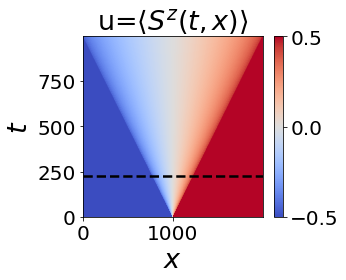

In [825]:
data_dict = load_dict('./data/zeroT_delta=0.npy')
# We truncate dataset by removing portion of the data at the beginning and the end of the evolution
start, stop = 150, -150
#########################

u = data_dict['u']
t = data_dict['t'][:-1]
x = data_dict['x']

xx, tt = np.meshgrid(x, t)

plt.pcolormesh(xx, tt, u, cmap='coolwarm', rasterized=True)
plt.colorbar()

plt.xlabel(r'$x$')
plt.ylabel(r'$t$')


plt.hlines(t[start], x[0], x[-1], ls='--')

plt.title(r'u=$\langle S^z(t, x) \rangle$')
plt.tight_layout()

window_length = 31
polyorder = 5  # should be odd
u = savgol_filter(u, window_length, polyorder, axis=1)

u = u[start:stop]
t = t[start:stop]

In [826]:
m, n = u.shape
dt = t[1]-t[0]
dx = x[1]-x[0]
print('Parameters of the dataset')
print('Nt, Nx: ', m, n)
print('Xmax, Tmax: ', x[-1], t[-1])
print('dt: ', dt, ' dx: ', dx)

Parameters of the dataset
Nt, Nx:  366 2000
Xmax, Tmax:  1999 772.5
dt:  1.5  dx:  1


## Build Library of Candidate Terms

We first differentiate the data along the spatial and temporal directions and construct a library of terms including nonlinearities and partial derivatives.  The matrix Theta is constructed so that each column is a potential term in the PDE, listed below.

In [827]:
# Here we set open boundary conditions. 
# This is important for the domain-wall initial state!
bc = "open"
# Compute temporal derivative u_t from the data
ut = TotalFiniteDiff_t(u, dt).reshape((n*m,1))

# Define a list of candidate terms
descr = [
           'u_x',
           'u*u_x', 
           'u^2*u_x', 
           'u^3*u_x',
           'u^4*u_x', 
           'u^5*u_x', 
           'u_xx', 
           'u_xxx', 
           'u_xxxx', 
        ]

u_data = []
for term in descr:
    u_data.append(get_u_term_from_descr(term, u, x, bc).reshape((n*m,1)))

u_data = np.hstack(u_data)
Theta, descr = build_custom_Theta(u_data, descr)

In [828]:
print(f'Considering {len(descr)} candidate terms {descr}')

Considering 9 candidate terms ['u_x', 'u*u_x', 'u^2*u_x', 'u^3*u_x', 'u^4*u_x', 'u^5*u_x', 'u_xx', 'u_xxx', 'u_xxxx']


In [829]:
xi, _ = BruteForceL0(Theta, ut, descr, l0_penalty=1e-4, verbose=False)

Best PDE found with BruteForce:
u_t = (-3.107207 +0.000000i)u*u_x
    + (4.527400 +0.000000i)u^3*u_x
   
Time elapsed (s): 63.82520508766174


In [777]:
print("Expected equation for Delta=0 (Tailor expansion of the exact equation):")
print_pde([-np.pi, np.pi**3/6, np.pi**5/120], ['u*u_x', 'u^3*u_x', 'u^5*u_x'], 'u_t');

Expected equation for Delta=0 (Tailor expansion of the exact equation):
u_t = (-3.141593 +0.000000i)u*u_x
    + (5.167713 +0.000000i)u^3*u_x
    + (2.550164 +0.000000i)u^5*u_x
   


## Compare solution of inferred PDE with data

In [730]:
# First, we specify the initial condition
u0 = u[0, :]
# Next, we solve the PDE
# (we freeze boundary conditions at the ends of the chain to avoid numerical instability)
u_pde = scalar_pde_solver(descr, xi, u0, t, x, bc="open", num_integrator_steps=25, 
                          fix_bndry=True, bndry_w=100, bndry_val_l=-0.5, bndry_val_r=0.5)

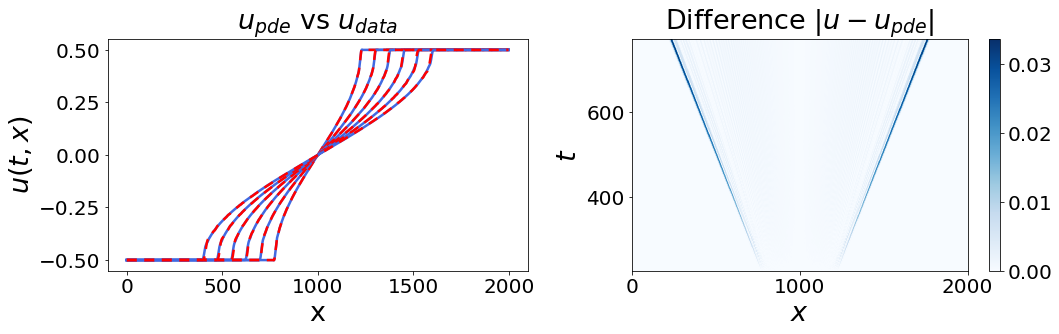

In [735]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));

for it in np.arange(0, 300, 50):
    ax[0].plot(u[it, :].real, c='royalblue', label='data')
    ax[0].plot(u_pde[it, :].real, ls='--', c='red', label='PDE', dashes=(4, 3))

ax[0].set_ylabel(r'$u(t,x)$')
ax[0].set_xlabel(r'x')
ax[0].set_title(r'$u_{pde}$ vs $u_{data}$')

xx, tt = np.meshgrid(x, t)
plt1 = ax[1].pcolormesh(xx, tt, abs(u-u_pde), cmap='Blues', rasterized=True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'Difference $|u-u_{pde}|$')
ax[1].set_xticks([0,1000, 2000])
fig.colorbar(plt1, ax=ax[1])
fig.tight_layout(pad=2)

### Lets extend the library of candidate terms by leveraging the prior knowledge of the theoretically expected terms: $\left\{u_x, u u_x, \ldots, u^5 u_x, \sin{\left(\frac{2\pi}{P_1} u\right)} u_x, \sin{\left(\frac{2\pi}{P_2} u\right)} u_x, \ldots\right\}$

In [839]:
# ux = TotalFiniteDiff(u, dx, 1).reshape((n*m,1))
# u_ = u.reshape((n*m,1))
# Theta_sin = np.array([]) #Theta.copy()
# descr_sin = [] #descr.copy()

# for i, den in enumerate(np.arange(1, 11)):
#     Theta_sin = np.hstack([Theta_sin, np.sin(2*pi/den*u_)*ux])
#     descr_sin.append(f'sin(2*pi/{den}*u)*u_x')

In [831]:
# Infer PDE from extended library (use STRidge algorithm for faster performance)
xi, _ = TrainSTRidge(Theta_sin, ut, descr_sin, 1e-5, 10, l0_penalty=5e-1)

In [819]:
print_pde(xi, descr_sin);

u_t = (-3.107226 +0.000000i)u*u_x
    + (4.527682 +0.000000i)u^3*u_x
   


# Now we consider XXZ model with $\Delta=0.5$ (data generated from TEBD simulations)

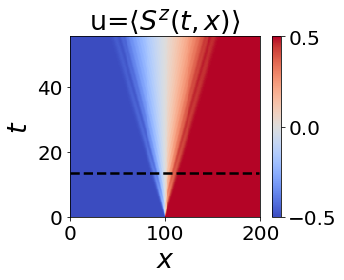

In [823]:
data_dict = load_dict('./data/zeroT_delta=0.5.npy')

start, stop = 50, -1
u = data_dict['u']
t = data_dict['t']
x = data_dict['x']

xx, tt = np.meshgrid(x, t)

plt.pcolormesh(xx, tt, u, cmap='coolwarm', rasterized=True)
plt.colorbar()

plt.xlabel(r'$x$')
plt.ylabel(r'$t$')

plt.hlines(t[start], x[0], x[-1], ls='--')
plt.title(r'u=$\langle S^z(t, x) \rangle$')
plt.xticks([0, 100, 200])
plt.tight_layout()

###############
window_length = 31
polyorder = 5  # should be odd
u = savgol_filter(u, window_length, polyorder, axis=1)
u = u[start:stop]
t = t[start:stop]

m, n = u.shape
dt = t[1]-t[0]
dx = x[1]-x[0]

In [824]:
# Here we set open boundary conditions 
# (it is important to set "open"  boundary conditions for the domain-wall initial state!)

bc = "open"
# Compute temporal derivative u_t from the data
ut = TotalFiniteDiff_t(u, dt).reshape((n*m,1))

# Define a list of candidate terms
descr = [
           'u_x',
           'u*u_x', 
           'u^2*u_x', 
           'u^3*u_x',
           'u^4*u_x', 
           'u^5*u_x', 
           'u_xx', 
           'u_xxx', 
           'u_xxxx', 
        ]

u_data = []
for term in descr:
    u_data.append(get_u_term_from_descr(term, u, x, bc).reshape((n*m,1)))

u_data = np.hstack(u_data)
Theta, descr = build_custom_Theta(u_data, descr)

In [786]:
xi, _ = BruteForceL0(Theta, ut, descr, 
                     l0_penalty=1e-2, verbose=False, lhs_descr='u_t')

Best PDE found with BruteForce:
u_t = (-1.878563 +0.000000i)u*u_x
   
Time elapsed (s): 0.9369299411773682


In [787]:
print("Expected equation for Delta=0.5 (Tailor expansion of the exact equation):")
a = 2*np.pi/3
print_pde([-a, a**3/6, a**5/120], ['u*u_x', 'u^3*u_x', 'u^5*u_x'], 'u_t');

Expected equation for Delta=0.5 (Tailor expansion of the exact equation):
u_t = (-2.094395 +0.000000i)u*u_x
    + (1.531174 +0.000000i)u^3*u_x
    + (0.335824 +0.000000i)u^5*u_x
   


In [788]:
# First, we specify the initial condition
u0 = u[0, :]
# Next, we solve the PDE
# (we freeze boundary conditions at the ends of the chain to avoid numerical instability)
u_pde = scalar_pde_solver(descr, xi, u0, t, x, bc="open", num_integrator_steps=25, 
                          fix_bndry=True, bndry_w=10, bndry_val_l=-0.5, bndry_val_r=0.5)

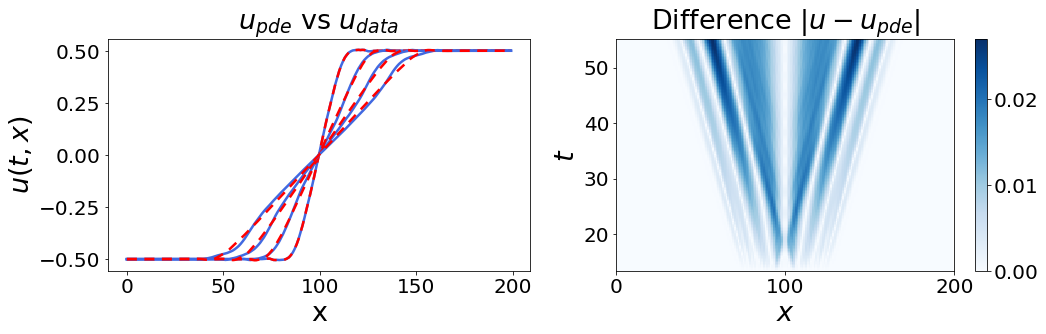

In [789]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5));

for it in np.arange(0, 200, 50):
    ax[0].plot(u[it, :].real, c='royalblue', label='data')
    ax[0].plot(u_pde[it, :].real, ls='--', c='red', label='PDE', dashes=(4, 3))

ax[0].set_ylabel(r'$u(t,x)$')
ax[0].set_xlabel(r'x')
ax[0].set_title(r'$u_{pde}$ vs $u_{data}$')

xx, tt = np.meshgrid(x, t)
plt1 = ax[1].pcolormesh(xx, tt, abs(u-u_pde), cmap='Blues', rasterized=True)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')
ax[1].set_title(r'Difference $|u-u_{pde}|$')
ax[1].set_xticks([0,100, 200])
fig.colorbar(plt1, ax=ax[1])
fig.tight_layout(pad=2)

## Bibliography
[1] M. Collura, A. De Luca, J. Viti, "Analytic solution of the domain-wall nonequilibriumstationary state", Phys. Rev. B97, 081111 (2018).